# Example of loading CSV files into a Graph

In [ ]:
%pip install networkx matplotlib scipy

In [1]:
import pandas as pd
import networkx as nx

# Initialize the graph
G = nx.Graph()

# -------------------------
# Load Author Nodes
# -------------------------
# CSV format: author_id, name
authors_df = pd.read_csv("GraphDataset/author.csv", header=None, names=["node_id", "name"])
for _, row in authors_df.iterrows():
    G.add_node(row["node_id"], type="author", name=row["name"])

# -------------------------
# Load Category Nodes
# -------------------------
# CSV format: category_id, name (e.g., "cs.LG")
categories_df = pd.read_csv("GraphDataset/category.csv", header=None, names=["node_id", "name"])
for _, row in categories_df.iterrows():
    G.add_node(row["node_id"], type="category", name=row["name"])

# -------------------------
# Load Organization Nodes
# -------------------------
# CSV format: organization_id, name
organizations_df = pd.read_csv("GraphDataset/organization.csv")
for _, row in organizations_df.iterrows():
    G.add_node(row["node_id"], type="organization", name=row["name"])

# -------------------------
# Load Paper Nodes
# -------------------------
# CSV format: paper_id, identifier, date, title
papers_df = pd.read_csv("GraphDataset/paper.csv", header=None, names=["node_id", "paper_id", "publish_date", "title"])
for _, row in papers_df.iterrows():
    G.add_node(row["node_id"], type="paper", paper_id=row["paper_id"], date=row["publish_date"], title=row["title"])

# -------------------------
# Load Paper-Author Relationships (Edges)
# -------------------------
# CSV format: paper_id, author_id
paper_author_df = pd.read_csv("GraphDataset/paper_author.csv", header=None, names=["paper_id", "author_id"])
for _, row in paper_author_df.iterrows():
    # Optionally check if both nodes exist
    if row["paper_id"] in G and row["author_id"] in G:
        G.add_edge(row["paper_id"], row["author_id"], relationship="written_by")
    else:
        print(f"Warning: Missing node for paper-author relationship: {row.to_dict()}")

# -------------------------
# Load Paper-Category Relationships (Edges)
# -------------------------
# CSV format: paper_id, category_id
# Note: the file is named 'paper_category.csv' per your example.
paper_category_df = pd.read_csv("GraphDataset/paper_category.csv", header=None, names=["paper_id", "category_id"])
for _, row in paper_category_df.iterrows():
    if row["paper_id"] in G and row["category_id"] in G:
        G.add_edge(row["paper_id"], row["category_id"], relationship="categorized_as")
    else:
        print(f"Warning: Missing node for paper-category relationship: {row.to_dict()}")

# -------------------------
# Load Paper-Organization Relationships (Edges)
# -------------------------
# CSV format: paper_id, organization_id
paper_org_df = pd.read_csv("GraphDataset/paper_organization.csv", header=None, names=["paper_id", "organization_id"])
for _, row in paper_org_df.iterrows():
    if row["paper_id"] in G and row["organization_id"] in G:
        G.add_edge(row["paper_id"], row["organization_id"], relationship="affiliated_with")
    else:
        print(f"Warning: Missing node for paper-organization relationship: {row.to_dict()}")

# -------------------------
# Summary Output
# -------------------------
print("Graph loaded successfully!")
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")


Graph loaded successfully!
Total Nodes: 26609
Total Edges: 47054


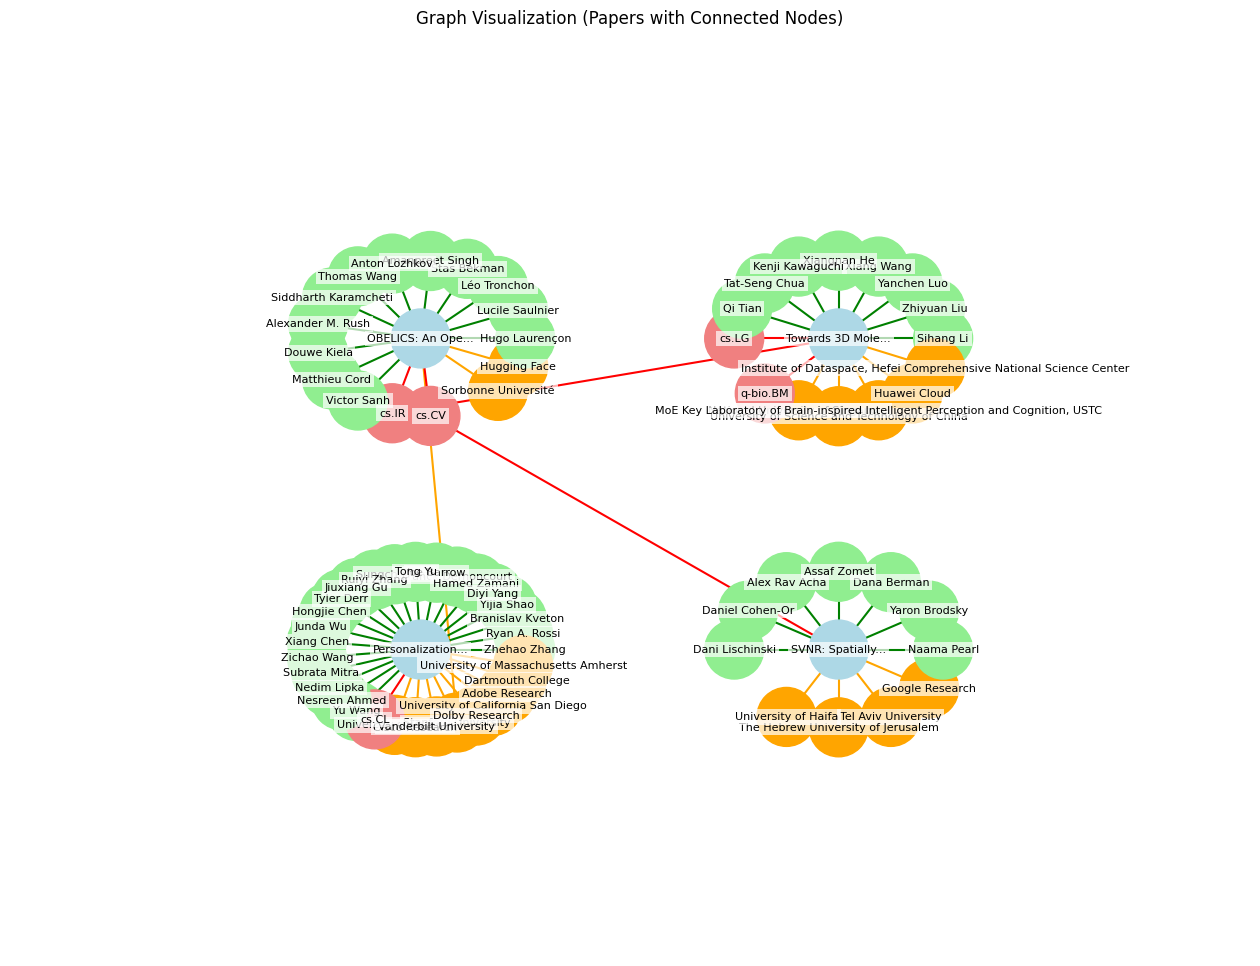

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Use specified paper IDs
paper_ids = ['paper_3929', 'paper_452', 'paper_448', 'paper_2056'] # Example paper IDs - replace with your list

# Get connected nodes, avoiding duplicate organizations
connected_nodes = set(paper_ids)
for paper in paper_ids:
    for neighbor in G.neighbors(paper):
        # Add all neighbors (authors, categories, organizations)
        connected_nodes.add(neighbor)

# Create subgraph with sampled papers and their connections        
subgraph = G.subgraph(connected_nodes)

# Custom layout - position papers further apart in corners
pos = {}
paper_positions = [
    (-3, -3),  # Bottom left
    (-3, 3),   # Top left
    (3, -3),   # Bottom right
    (3, 3)     # Top right
]

# Position papers first
for i, paper in enumerate(paper_ids):
    if i < len(paper_positions):
        pos[paper] = paper_positions[i]

# Position connected nodes in a wider circle around their respective papers
for i, paper in enumerate(paper_ids):
    if i >= len(paper_positions):
        break
        
    neighbors = list(subgraph.neighbors(paper))
    num_neighbors = len(neighbors)
    
    if num_neighbors > 0:
        radius = 1.5  # Increased radius for more spacing
        for j, neighbor in enumerate(neighbors):
            if neighbor not in pos:  # Only position if not already positioned
                angle = 2 * np.pi * j / num_neighbors
                x = paper_positions[i][0] + radius * np.cos(angle)
                y = paper_positions[i][1] + radius * np.sin(angle)
                pos[neighbor] = (x, y)

# For any remaining unpositioned nodes, use spring layout with more spacing
remaining_nodes = [n for n in subgraph.nodes() if n not in pos]
if remaining_nodes:
    remaining_pos = nx.spring_layout(subgraph.subgraph(remaining_nodes), k=3)
    pos.update(remaining_pos)

# Draw nodes with colors based on type
node_colors = []
for node in subgraph.nodes(data=True):
    if node[1]['type'] == 'paper':
        node_colors.append('lightblue')
    elif node[1]['type'] == 'author':
        node_colors.append('lightgreen') 
    elif node[1]['type'] == 'category':
        node_colors.append('lightcoral')
    elif node[1]['type'] == 'organization':
        node_colors.append('orange')
    else:
        node_colors.append('grey')

# Increase figure size significantly for better spacing
plt.figure(figsize=(16, 12))

nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=1800)

# Draw edges with different colors based on relationship type
edge_colors = []
for (u, v, data) in subgraph.edges(data=True):
    if data.get('relationship') == 'written_by':
        edge_colors.append('green')
    elif data.get('relationship') == 'categorized_as':
        edge_colors.append('red')
    elif data.get('relationship') == 'affiliated_with':
        edge_colors.append('orange')
    else:
        edge_colors.append('gray')

nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=1.5)

# Add labels for the nodes using names instead of IDs, with bbox for better readability
labels = {}
for node, attr in subgraph.nodes(data=True):
    if attr['type'] == 'paper':
        # Use truncated paper title for cleaner visualization
        title = attr['title']
        labels[node] = title[:15] + '...' if len(title) > 15 else title
    elif attr['type'] == 'author':
        labels[node] = attr['name']
    elif attr['type'] == 'category':
        labels[node] = attr['name']
    elif attr['type'] == 'organization':
        labels[node] = attr['name']
    else:
        labels[node] = node
        
nx.draw_networkx_labels(subgraph, pos, labels, font_size=8, 
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))

plt.title("Graph Visualization (Papers with Connected Nodes)")
plt.axis('off')

# Add more margin around the plot
plt.margins(0.4)

plt.show()
